# 1. Dataset

In [ ]:
# Unzip dataset
!tar -xvzf /content/drive/MyDrive/Naver/마스크분류/data/data.tar.gz

# Module

In [ ]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from tqdm.notebook import tqdm
from time import time

import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp

In [ ]:
class cfg:
  data_dir = '/content/train'
  img_dir = f'{data_dir}/images'
  df_path = f'{data_dir}/train.csv'

In [ ]:
num2class = ['incorrect_mask', 'mask1', 'mask2', 'mask3',
             'mask4', 'mask5', 'normal']
class2num = {k: v for v, k in enumerate(num2class)}

df = pd.read_csv(cfg.df_path)
df.head()

id  gender   race  age                    path
0  000001  female  Asian   45  000001_female_Asian_45
1  000002  female  Asian   52  000002_female_Asian_52
2  000004    male  Asian   54    000004_male_Asian_54
3  000005  female  Asian   58  000005_female_Asian_58
4  000006  female  Asian   59  000006_female_Asian_59

# 1. 이미지 RGB 정보, 사이즈

## 1.1 Dataste statistics

In [ ]:
def get_ext(img_dir, img_id):
  '''
  Args:
  img_dir : 학습 데이터셋 이미지 폴더 경로
  img_id : 학습 데이터셋 하위폴더 이름
  '''
  filename = os.listdir(os.path.join(img_dir,img_id))[0]
  ext = os.path.splitext(filename)[-1].lower()
  return ext

In [ ]:
get_ext(cfg.img_dir, df.path.values[0])

'.jpg'

In [ ]:
# 데이터셋에 있는 이미지들의 크기와 RGB 평균 및 표준편차를 수집하는 함수
def get_img_stats(img_dir, img_ids):

  img_info = dict(heights=[],widths=[],means=[],stds=[])

  for img_id in tqdm(img_ids):
    for path in glob(os.path.join(img_dir,img_id,'*')):
      img = np.array(Image.open(path))
      h,w,_ = img.shape
      img_info['heights'].append(h)
      img_info['widths'].append(w)
      img_info['means'].append(img.mean(axis=(0,1)))
      img_info['stds'].append(img.std(axis=(0,1)))

  return img_info

In [ ]:
img_info = get_img_stats(cfg.img_dir, df.path.values[:100])

print(f'Total number of people is {len(df)}')
print(f'Total number of images is {len(df) * 7}')

print(f'Minimum height for dataset is {np.min(img_info["heights"])}')
print(f'Maximum height for dataset is {np.max(img_info["heights"])}')
print(f'Average height for dataset is {int(np.mean(img_info["heights"]))}')
print(f'Minimum width for dataset is {np.min(img_info["widths"])}')
print(f'Maximum width for dataset is {np.max(img_info["widths"])}')
print(f'Average width for dataset is {int(np.mean(img_info["widths"]))}')

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')

  0%|          | 0/100 [00:00<?, ?it/s]

Total number of people is 2700
Total number of images is 18900
Minimum height for dataset is 512
Maximum height for dataset is 512
Average height for dataset is 512
Minimum width for dataset is 384
Maximum width for dataset is 384
Average width for dataset is 384
RGB Mean: [0.55800662 0.51224152 0.47766819]
RGB Standard Deviation: [0.21789488 0.23798859 0.25171667]


## 1.2 객체의 위치 확인

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [ ]:
imgs = []
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir,img_id)
for class_id in num2class:
  img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
  imgs.append(img)
imgs = np.array(imgs)

In [ ]:
len(imgs)

7

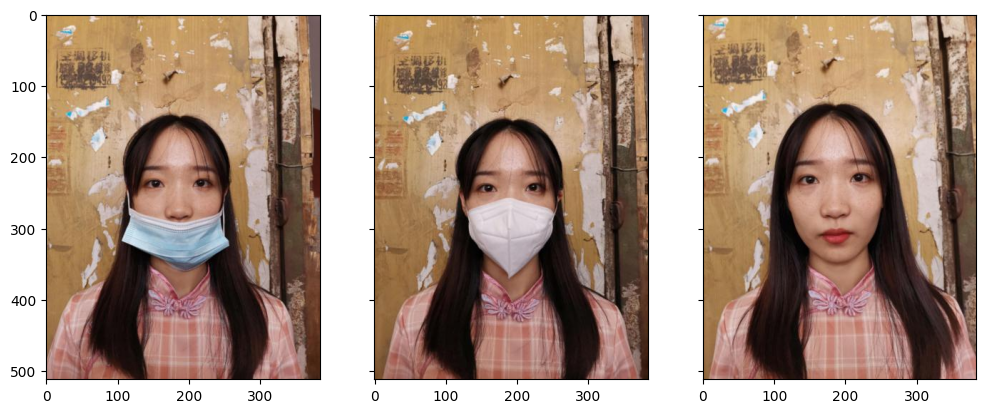

In [ ]:
fig, axes = plt.subplots(1,3,sharex=True, sharey=True, figsize=(12,6))
axes[0].imshow(imgs[0])
axes[1].imshow(imgs[1])
axes[2].imshow(imgs[-1])
plt.show()

# 2. Target 값 y에 대한 분석

## 2.1 y값 독립적 분포 확인

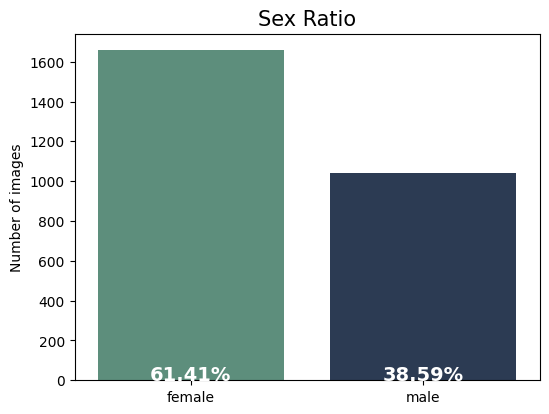

In [ ]:
plt.figure(figsize=(6,4.5))
ax = sns.countplot(x='gender',data=df,palette=['#55967e','#263959'])

plt.xticks(np.arange(2),['female','male'])
plt.title('Sex Ratio',fontsize=15)
plt.xlabel('')
plt.ylabel('Number of images')

counts = df.gender.value_counts()
counts_pct = [f'{elem*100:.2f}%' for elem in counts / counts.sum()]
for i,v in enumerate(counts_pct):
  ax.text(i,0,v,horizontalalignment='center',size=14,color='w',fontweight='bold')
plt.show()

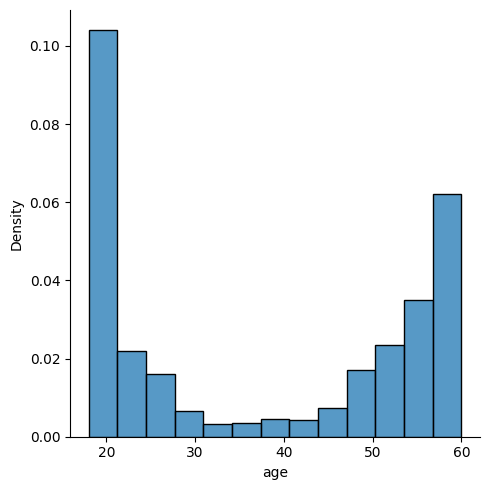

In [ ]:
sns.displot(df, x='age',stat='density')
plt.show()

## 2.2 y값들 간의 관계 분포

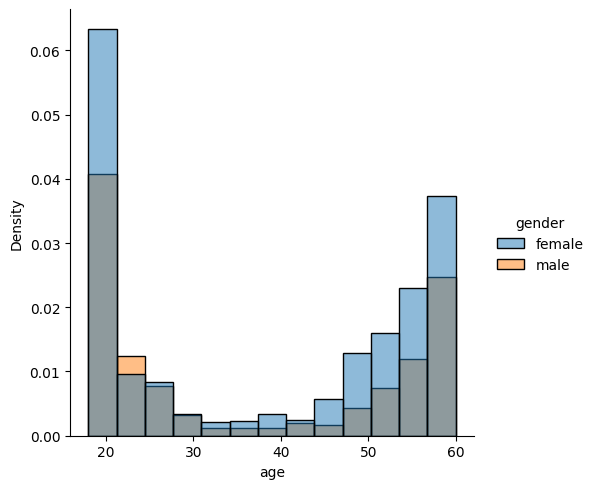

In [ ]:
sns.displot(df, x='age',hue='gender',stat='density')
plt.show()

In [ ]:
df['age'].describe()

count    2700.000000
mean       37.708148
std        16.985904
min        18.000000
25%        20.000000
50%        36.000000
75%        55.000000
max        60.000000
Name: age, dtype: float64

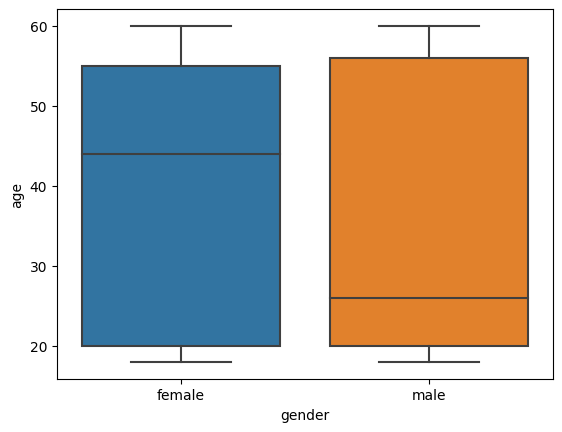

In [ ]:
sns.boxplot(x='gender',y='age',data=df)
plt.show()

- 남성과 여성의 나이 범위는 같지만 경향성은 다름
- 데이터 불균형이 심함

# 3. X,y 관계 확인

## 3.1 이미지 사이즈와 y 값의 관계

- Image size는 모두 같은 사이즈라 y 값과 관계 없음

## 3.2 이미지 RGB 통계값과 y 특성의 관계

In [ ]:
img_id = df.iloc[500].path
ext = get_ext(cfg.img_dir,img_id)

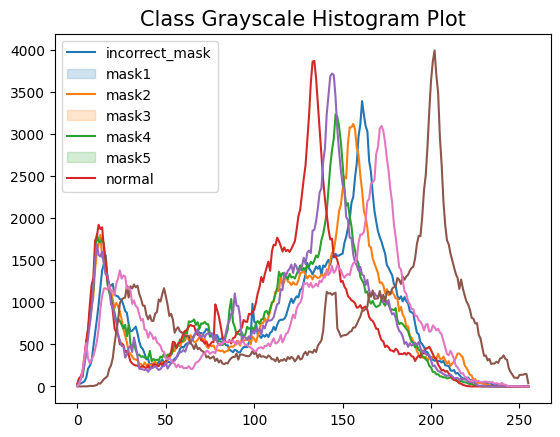

In [ ]:
plt.figure()
plt.subplot(111)

for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)).convert('L'))
    histogram, bin_edges = np.histogram(img, bins=256, range=(0, 255))
    sns.lineplot(data=histogram)

plt.legend(num2class)
plt.title('Class Grayscale Histogram Plot', fontsize=15)
plt.show()

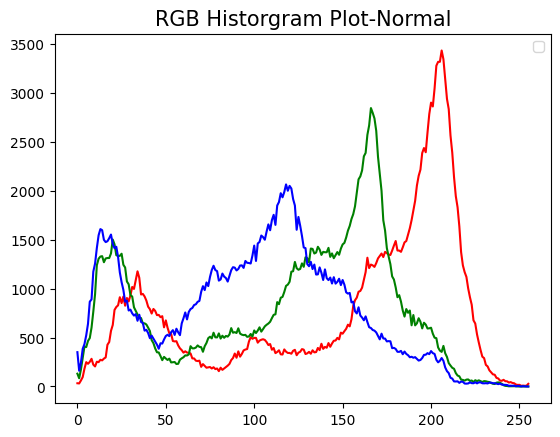

In [ ]:
plt.figure()
plt.subplot(111)

img = np.array(Image.open(os.path.join(cfg.img_dir,img_id,'normal'+ext)))
colormap = ['red','green','blue']
for i in range(3):
    histogram, bin_edges = np.histogram(img[:,:,i], bins=256, range=(0, 255))
    sns.lineplot(data=histogram,color=colormap[i])

plt.legend()
plt.title('RGB Historgram Plot-Normal',fontsize=15)
plt.show()

## 3.3 객체의 위치와 y의 관계

In [ ]:
imgs = []
bboxes = []
not_found_idx = []
img_id = df.iloc[504].path
ext = get_ext(cfg.img_dir,img_id)

for i, class_id in enumerate(num2class):
  img = np.array(Image.open(os.path.join(cfg.img_dir, img_id, class_id+ext)))
  bbox = face_cascade.detectMultiScale(img)
  imgs.append(img)

  if len(bbox) != 0:
    bboxes.append(bbox.max(axis=0))
  else:
    not_found_idx.append(i)
    print(f'{class_id} not found face')
imgs = np.array(imgs)
bboxes = np.array(bboxes)

incorrect_mask not found face
mask1 not found face
mask5 not found face


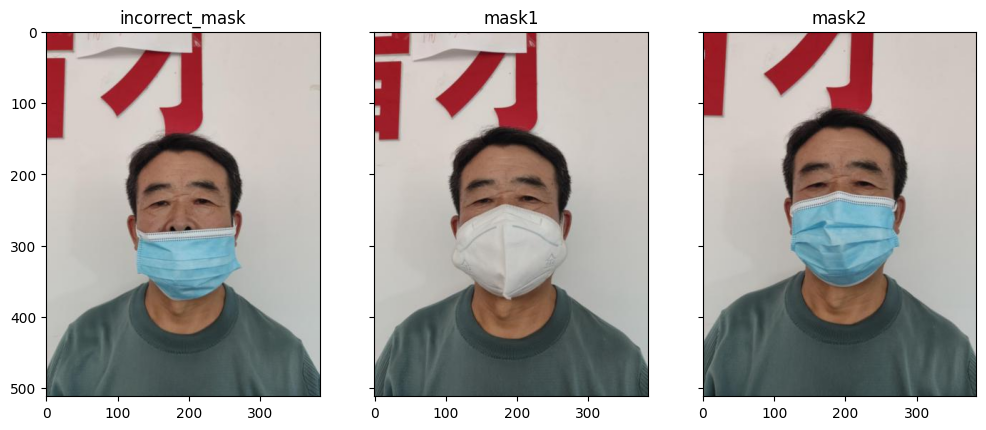

In [ ]:
fig, axes = plt.subplots(1,len(not_found_idx),sharex=True, sharey=True, figsize=(12,6))

for i, j in enumerate(range(len(not_found_idx))):
  axes[i].imshow(imgs[j])
  axes[i].set_title(f'{num2class[j]}')
plt.show()

대부분의 이미지들은 인물들이 정중앙

## 3.4 데이터 노이즈 확인
- 사람마다 총 7장의 사진이 존재합니다. (마스크 정상 착용 5장, 미착용 1장, 이상하게 착용 1장).
- 이 파트에서는 이미지를 직접 시각화하여 눈으로 관찰하여 label에 문제가 없는지 확인해봅시다.


In [ ]:
# 마스크 미착용 이미지를 시각화

def plot_raw_images(img_dir, img_id):
  ext = get_ext(img_dir, img_id)
  img = np.array(Image.open(os.path.join(img_dir,img_id,'normal'+ext)))

  plt.figure(figsize=(6,6))
  plt.imshow(img)

In [ ]:
def show_from_id(idx):
  img_id = df.iloc[idx].path
  gen = df.iloc[idx].gender
  age = df.iloc[idx].age
  plot_raw_images(cfg.img_dir,img_id)
  plt.title(f'{gen} {age}')
  plt.show()

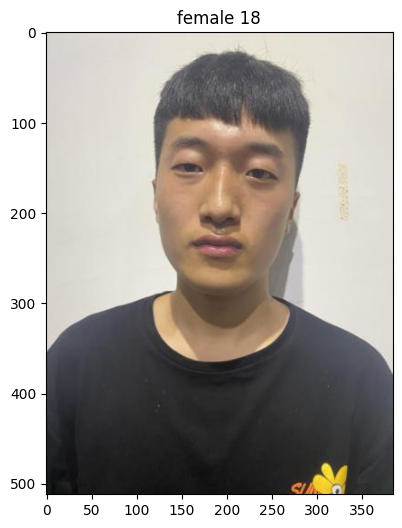

In [ ]:
show_from_id(2399)

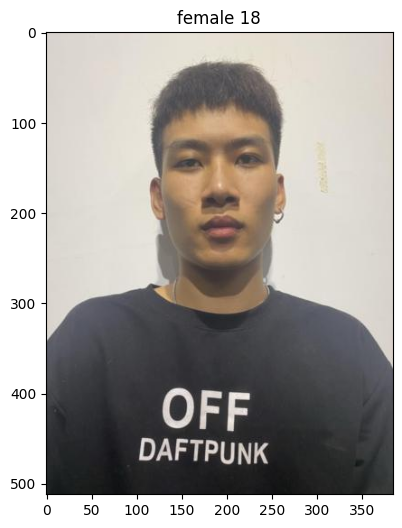

In [ ]:
show_from_id(2400)

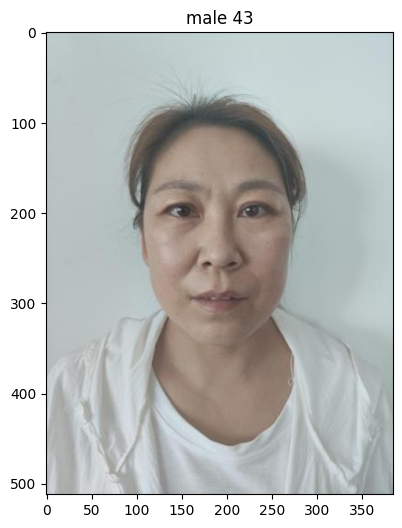

In [ ]:
show_from_id(1912)

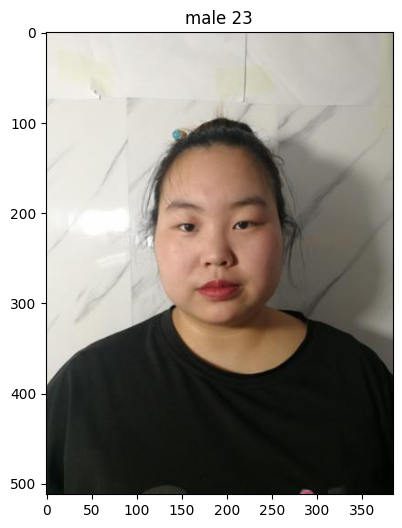

In [ ]:
show_from_id(764)

In [ ]:
# 마스크 정상착용 5장과 이상하게 착용한 1장을 2 x 3의 격자에 시각화

def plot_mask_images(img_dir, img_id):

  ext = get_ext(img_dir, img_id)
  imgs = [np.array(Image.open(os.path.join(img_dir, img_id, class_name + ext))) for class_name in num2class[:-1]]

  n_rows, n_cols = 2, 3
  fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(15,12))
  for i in range(n_rows * n_cols):
    axes[i//(n_rows+1)][i%n_cols].imshow(imgs[i])
    axes[i//(n_rows+1)][i%n_cols].set_title(f'{num2class[i]}',color='r')
  plt.tight_layout()
  plt.show()

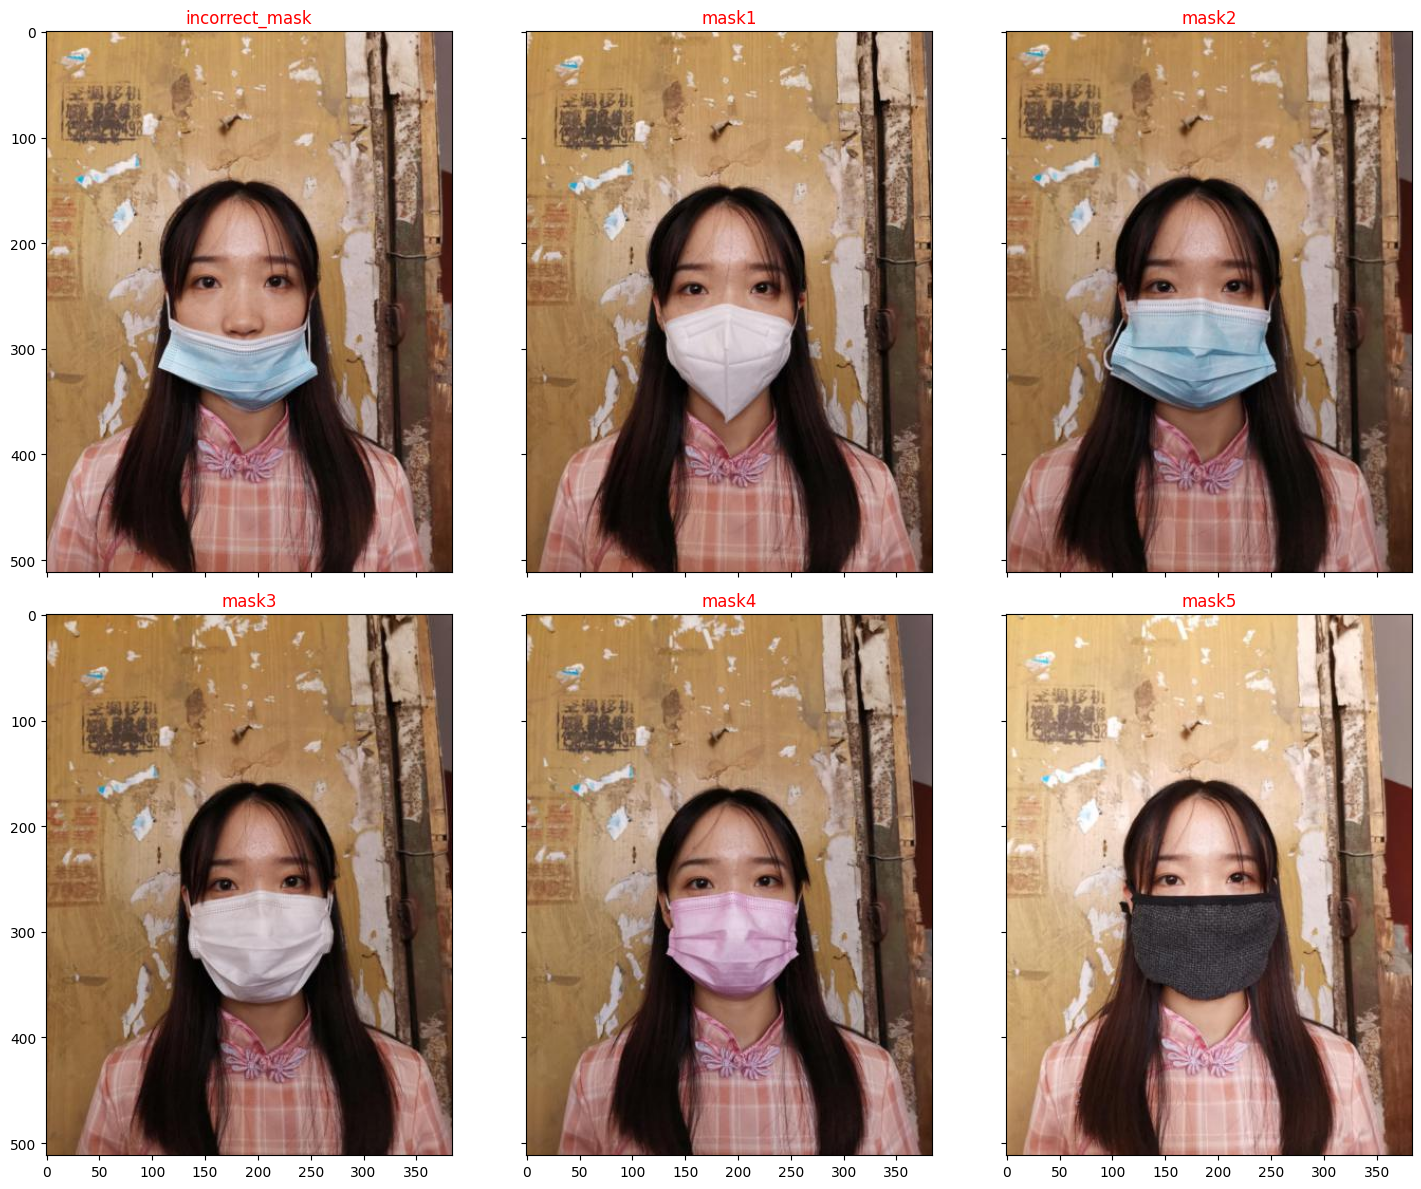

In [ ]:
idx = 500
img_id = df.iloc[idx].path
plot_mask_images(cfg.img_dir, img_id)

# (Optional) PCA
- 주성분 분석은 이미지 데이터 분포의 주성분을 구하는 방법입니다.
- 300 장의 얼굴 이미지에 대한 주성분 벡터(eigenface)를 구하고 T-SNE를 통해 차원축소를 하여 각 클래스마다의 분포차이를 시각화해봅시다.

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
n_imgs = 100

imgs = []
for img_id in df.path.values[:n_imgs]:
  for class_id in num2class:
    img = np.array(Image.open(os.path.join(cfg.img_dir, img_id,class_id+ext)).convert('L'))
    imgs.append(img)

imgs = np.array(imgs)
n_samples, h, w = imgs.shape

imgs = np.reshape(imgs,(n_samples,h*w))

In [ ]:
n_components = 30

t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(imgs)
print(f"pca is fitted in {time() - t0:.0f}s")
print(f'Explained variation per principal component: \n{pca.explained_variance_ratio_}')

eigenfaces = pca.components_.reshape((n_components, h, w))
img_pca = pca.transform(imgs)

pca is fitted in 24s
Explained variation per principal component: 
[0.16400328 0.10583061 0.07423401 0.05696065 0.03344143 0.02725811
 0.02416491 0.02329299 0.02024698 0.01692823 0.01573051 0.0135788
 0.01292895 0.0118508  0.01141356 0.00954073 0.00822209 0.00784373
 0.00709925 0.0067026  0.00646111 0.0062661  0.00592058 0.00564944
 0.00546248 0.00517161 0.00475356 0.00465627 0.00437845 0.00421361]


In [ ]:
pca_df = pd.DataFrame(img_pca, columns=[str(col) for col in range(n_components)])
pca_df['class_id'] = [num2class[n % len(num2class)] for n in range(n_samples)]
pca_df['class_id'] = pca_df['class_id'].map(lambda x: x if x in ['incorrect_mask', 'normal'] else 'mask')

In [ ]:
pca_df.head()

0         1         2         3         4         5         6  \
0 -0.780928 -0.301785  0.909879  0.561677  0.377160  0.319318  0.490583   
1 -1.530998  0.054308  1.062859  0.448517  0.221639  0.127035 -0.152808   
2 -0.878974 -0.366530  0.961204  0.348114  0.147959 -0.001420  0.647866   
3 -0.354728 -0.443177  1.248912  0.965023  0.401113  0.732332  0.595702   
4 -0.526049 -0.342641  1.048807  0.778380  0.344757  0.535216  0.592012   

          7         8         9  ...        21        22        23        24  \
0 -0.157287  0.226582 -0.055651  ...  1.407453  0.703861  1.014345  1.010930   
1  2.102633  2.525300  0.800275  ... -0.560287 -0.490439 -0.538204 -0.559693   
2 -0.286866  0.415878  0.085197  ...  0.997470  0.482396  0.439304  1.307703   
3 -0.243740  0.063749  0.278055  ...  1.053071 -0.557269  0.292154  0.390705   
4 -0.187867  0.033170  0.083710  ...  1.544365  0.074907  1.001982  0.748569   

         25        26        27        28        29        class_id  
0  0.264477 -0.617426 -0.006426  1.167594 -1.289023  incorrect_mask  
1  1.190734 -0.674060  0.043366  0.460995 -0.431071            mask  
2 -0.008659 -0.484906 -0.011124  0.993989 -0.532928            mask  
3 -0.816010 -0.686434 -0.870634  0.820360 -0.273095            mask  
4 -0.298244 -1.009984 -0.599529  1.314346 -1.458334            mask  

[5 rows x 31 columns]

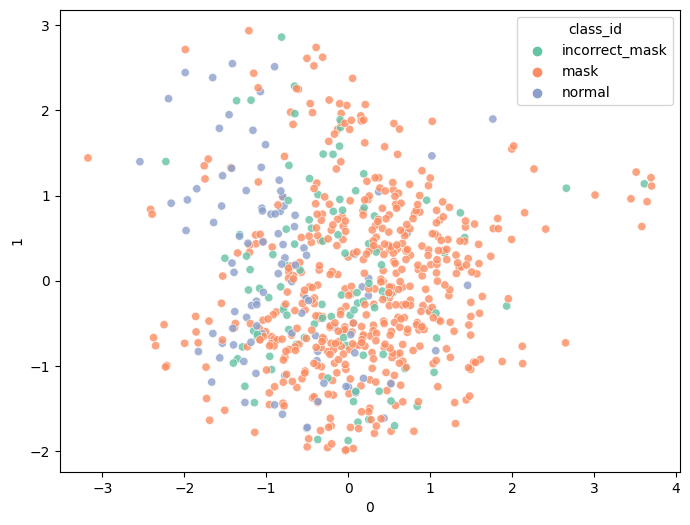

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='0', y='1',
    hue="class_id",
    data=pca_df,
    legend="full",
    palette=sns.color_palette("Set2", 3),
    alpha=0.8
)
plt.show()

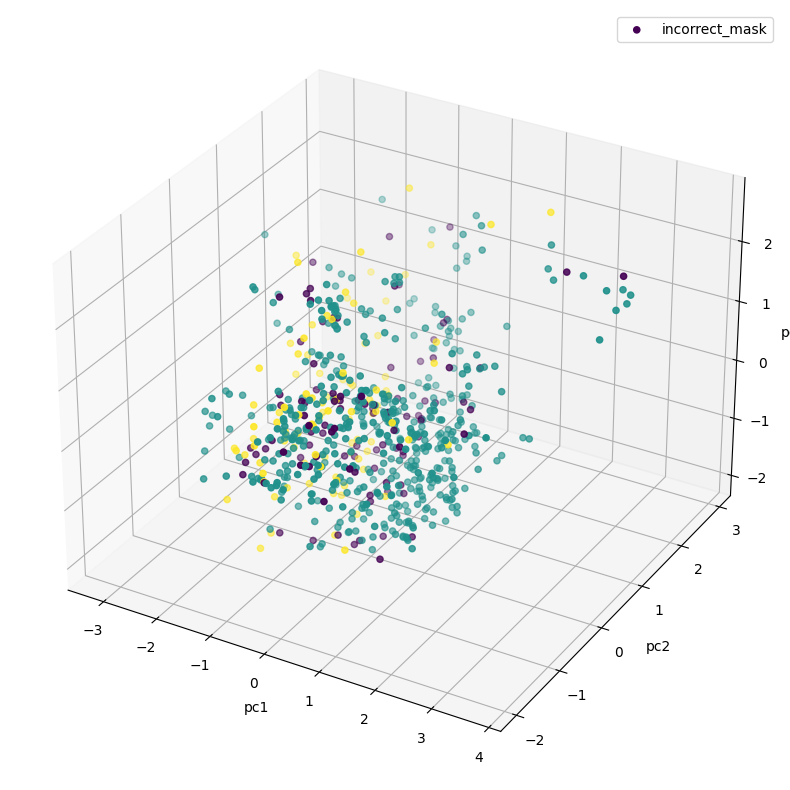

In [ ]:
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(projection='3d')
simplified_num2class = ['incorrect_mask', 'mask', 'normal']
simplified_class2num = {k: v for v, k in enumerate(simplified_num2class)}
ax.scatter(
    xs=pca_df["0"],
    ys=pca_df["1"],
    zs=pca_df["2"],
    c=pca_df['class_id'].map(lambda x: simplified_class2num[x]),
)
ax.set_xlabel('pc1')
ax.set_ylabel('pc2')
ax.set_zlabel('pc3')

plt.legend(simplified_num2class)
plt.show()

In [ ]:
time_start = time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(img_pca)
print('t-SNE done! Time elapsed: {} seconds'.format(time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 700 samples in 0.001s...
[t-SNE] Computed neighbors for 700 samples in 0.065s...
[t-SNE] Computed conditional probabilities for sample 700 / 700
[t-SNE] Mean sigma: 2.322851
[t-SNE] KL divergence after 100 iterations with early exaggeration: 61.308262
[t-SNE] KL divergence after 300 iterations: 1.076207
t-SNE done! Time elapsed: 3.3184192180633545 seconds


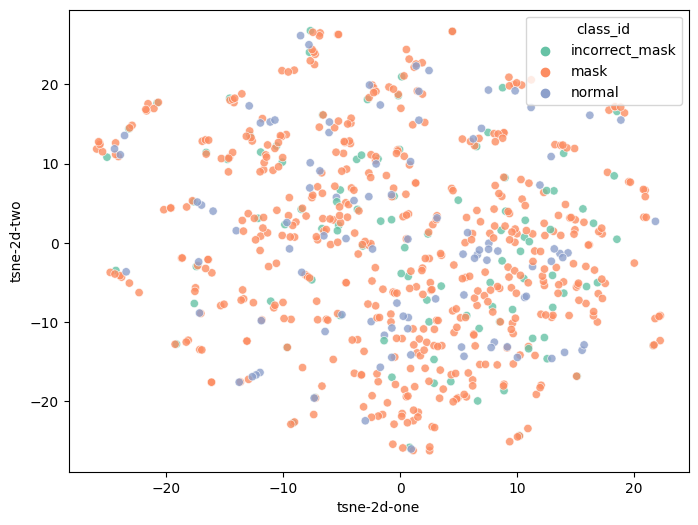

In [ ]:
pca_df['tsne-2d-one'] = tsne_results[:,0]
pca_df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class_id",
    palette=sns.color_palette("Set2", 3),
    data=pca_df,
    legend="full",
    alpha=0.8
)
plt.show()